# 네이버 댓글 자연어 처리

# 
## 데이터
 - 네이버 댓글 : [Naver sentiment movie corpus](https://github.com/e9t/nsmc)

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [3]:
print(len(train_data), len(test_data))

150000 50000


In [ ]:
# ##TEST용
# train_data = train_data[:100]
# test_data = test_data[:100]

- 15만개의 데이터 중 오류를 내는 데이터를 검출해보자.
- [25521]: nan
- [39894]: ㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇ

---
TEST LINE

In [4]:
for data in [train_data, test_data] : 
    data.drop_duplicates(subset=['document'], inplace=True)
    data = data.dropna(how = 'any').reset_index(drop=True)

In [ ]:
print(len(train_data), len(test_data))

---

## 데이터로더 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import *
from nltk import Text
from nltk import FreqDist
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# test

- 오류 데이터 제외

In [4]:
def load_data(train_data, test_data, num_words=10000):
    for data in [train_data, test_data] : 
        data.drop_duplicates(subset=['document'], inplace=True)
        data = data.dropna(how = 'any') 
    
    train_err_list = []    
    X_train = []
    for idx, sentence in enumerate(train_data['document']):
        try:
            temp_X = tokenizer.morphs(sentence) # 토큰화
            temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
            X_train.append(temp_X)
        except:
            print(f'[{idx}]: {sentence}')
            train_err_list.append(idx)
    
    test_err_list = []
    X_test = []
    for idx, sentence in enumerate(test_data['document']):
        try:
            temp_X = tokenizer.morphs(sentence) # 토큰화
            temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
            X_test.append(temp_X)
        except:
            print(f'[{idx}]: {sentence}')
            test_err_list.append(idx)

    # 오류난 문장들을 제거해주는 연산_ver2
    for ii, idx in enumerate(train_err_list) :
        del train_data['label'][idx - ii]
        
    for ii, idx in enumerate(test_err_list) :
        del test_data['label'][idx - ii]
            
    words = np.concatenate(X_train).tolist()
    txt_X_train = Text(words)
    freq_X_train = txt_X_train.vocab()
    counter = freq_X_train.most_common(num_words-4) #[(단어, 횟수)]
    
#     counter = Counter(words)
#     counter = counter.most_common(10000-4)

    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    
# 오류난 문장들을 제거해주는 연산_ver1
#     temp = np.array([])
#     lower_idx = 0
#     for idx in train_err_list:
#         temp = np.concatenate([temp, train_data['label'][lower_idx:idx]])
#         lower_idx = idx + 1
#         if idx == train_err_list[-1] :
#             temp = np.concatenate([temp, train_data['label'][lower_idx:]])
#     y_train = temp
    
#     temp2 = np.array([])
#     lower_idx = 0
#     for idx in test_err_list:
#         temp2 = np.concatenate([temp2, test_data['label'][lower_idx:idx]])
#         lower_idx = idx + 1
#         if idx == test_err_list[-1] :
#             temp2 = np.concatenate([temp2, test_data['label'][lower_idx:]])
#     y_test = temp2
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
 

---
X_train, X_test에서 예외처리 한 값들 처리(임시방편)

In [5]:
temp = [i for i in range(10)]
print(temp)
for idx, i in enumerate([0, 2, 4]):
    del temp[i - idx ]
temp

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


[1, 3, 5, 6, 7, 8, 9]

In [ ]:
temp = np.array([i for i in range(10)])
temp = np.concatenate([temp[:1], temp[2:]])
temp

In [ ]:
len(X_train)

In [ ]:
temp = np.array([])
lower_idx = 0
for idx in [25521, 39894, 122796, 142389]:
    temp = np.concatenate([temp, y_train[lower_idx:idx]])
    lower_idx = idx + 1
    if idx == 142389 :
        temp = np.concatenate([temp, y_train[lower_idx:]])
y_train = temp

temp2 = np.array([])
lower_idx = 0
for idx in [5704, 32957, 34277, 35737]:
    temp2 = np.concatenate([temp2, y_test[lower_idx:idx]])
    lower_idx = idx + 1
    if idx == 35737 :
        temp2 = np.concatenate([temp2, y_test[lower_idx:]])
y_test = temp2

assert len(X_train) == len(y_train), len(X_test) == len(y_test)

---

In [6]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
# load_data(train_data, test_data) 
index_to_word = {index:word for word, index in word_to_index.items()}

[25521]: nan
[5704]: nan


In [7]:
# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

# 문장의 길이

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다.


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


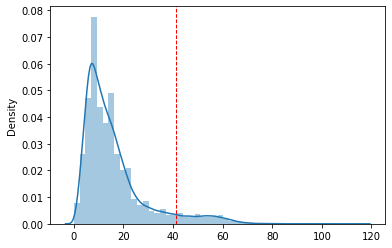

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다.')

sns.distplot(num_tokens)
plt.axvline(maxlen, color = 'r',ls = '--', linewidth = 1)

In [10]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 모델구성 및 validation set 구성
 - 3가지 이상의 다양한 구성

In [11]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

## 모델1

In [12]:
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


## 모델2

In [13]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

## 모델3

In [14]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


## 모델 훈련

In [15]:
epochs = 10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

models = [model1, model2, model3]
histories = []
history_dicts = []
results = []
for idx, model in enumerate(models):
    model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    histories.append(model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_split=0.2,
                    verbose=1))
    history_dicts.append(histories[idx].history)
    
    results.append(model.evaluate(X_test,  y_test, verbose=2))

    print(results)

Epoch 1/10
229/229 [==============================] - 6s 13ms/step - loss: 0.6184 - accuracy: 0.6651 - val_loss: 0.4698 - val_accuracy: 0.8324
Epoch 2/10
229/229 [==============================] - 2s 10ms/step - loss: 0.4329 - accuracy: 0.8421 - val_loss: 0.3832 - val_accuracy: 0.8330
Epoch 3/10
229/229 [==============================] - 2s 10ms/step - loss: 0.3459 - accuracy: 0.8552 - val_loss: 0.3495 - val_accuracy: 0.8507
Epoch 4/10
229/229 [==============================] - 2s 10ms/step - loss: 0.3217 - accuracy: 0.8663 - val_loss: 0.3481 - val_accuracy: 0.8517
Epoch 5/10
229/229 [==============================] - 2s 10ms/step - loss: 0.3125 - accuracy: 0.8710 - val_loss: 0.3486 - val_accuracy: 0.8517
Epoch 6/10
229/229 [==============================] - 2s 10ms/step - loss: 0.3049 - accuracy: 0.8741 - val_loss: 0.3437 - val_accuracy: 0.8527
Epoch 7/10
229/229 [==============================] - 2s 10ms/step - loss: 0.3019 - accuracy: 0.8764 - val_loss: 0.3428 - val_accuracy: 0.8535

## Loss, Accuracy 그래프 시각화

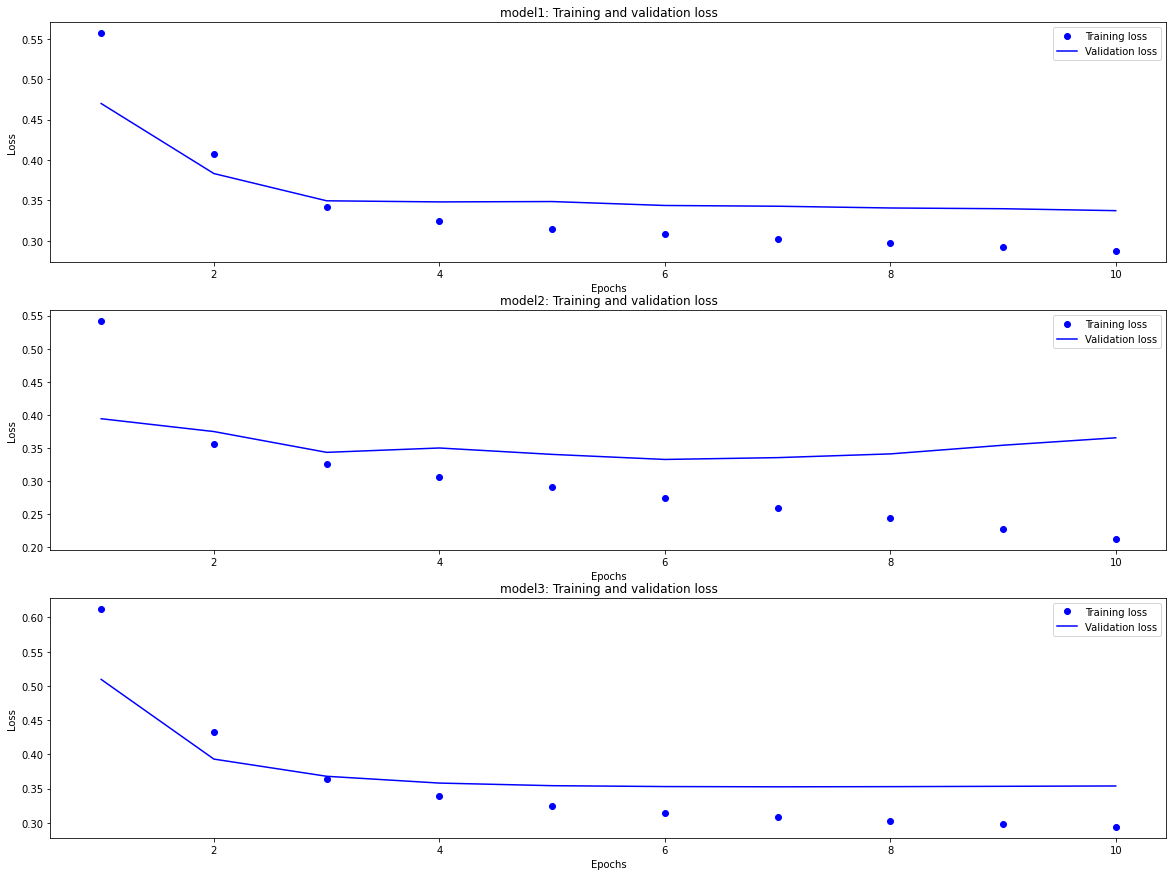

In [16]:
fig, axes = plt.subplots(3,1, figsize=(20,15))

for idx, ax in enumerate(axes) :
    acc = history_dicts[idx]['accuracy']
    val_acc = history_dicts[idx]['val_accuracy']
    loss = history_dicts[idx]['loss']
    val_loss = history_dicts[idx]['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo"는 "파란색 점"입니다
    ax.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    ax.plot(epochs, val_loss, 'b', label='Validation loss')
    ax.set_title(f'model{idx+1}: Training and validation loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

plt.show()

## 학습된 Embedding 레이어 분석

- 가장 성능이 좋았던 모델 기준으로, Embedding Layer 적용 결과 16-dim의 벡터를 얻을 수 있음을 알 수 있다!


In [37]:
model1.layers[0](X_train)

<tf.Tensor: shape=(146182, 41, 16), dtype=float32, numpy=
array([[[-0.01810664, -0.02048413,  0.0427878 , ..., -0.01769658,
          0.00975205,  0.06761301],
        [-0.01810664, -0.02048413,  0.0427878 , ..., -0.01769658,
          0.00975205,  0.06761301],
        [-0.01810664, -0.02048413,  0.0427878 , ..., -0.01769658,
          0.00975205,  0.06761301],
        ...,
        [-0.00823269,  0.00585966, -0.01963153, ..., -0.07385854,
          0.00304255,  0.02448767],
        [-0.0472527 , -0.00299098,  0.0237246 , ..., -0.08318406,
          0.04224602, -0.15888959],
        [ 0.01446805,  0.03053502, -0.02359521, ...,  0.02106308,
          0.03274518, -0.00469517]],

       [[-0.01810664, -0.02048413,  0.0427878 , ..., -0.01769658,
          0.00975205,  0.06761301],
        [-0.01810664, -0.02048413,  0.0427878 , ..., -0.01769658,
          0.00975205,  0.06761301],
        [-0.01810664, -0.02048413,  0.0427878 , ..., -0.01769658,
          0.00975205,  0.06761301],
        .

## 한국어 Word2Vec 임베딩 활용하여 성능개선
 - 출처 : [Pre-trained word vectors of 30+ languages](https://github.com/Kyubyong/wordvectors)

In [18]:
import os
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
# vector = word2vec['computer']
# vector     # 무려 300dim의 워드 벡터입니다.

In [19]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [23]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 9888      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


In [24]:
# 학습의 진행
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/10
229/229 [==============================] - 10s 35ms/step - loss: 0.6452 - accuracy: 0.6362 - val_loss: 0.4850 - val_accuracy: 0.8061
Epoch 2/10
229/229 [==============================] - 7s 31ms/step - loss: 0.4449 - accuracy: 0.8211 - val_loss: 0.3783 - val_accuracy: 0.8390
Epoch 3/10
229/229 [==============================] - 7s 30ms/step - loss: 0.3594 - accuracy: 0.8510 - val_loss: 0.3558 - val_accuracy: 0.8462
Epoch 4/10
229/229 [==============================] - 7s 30ms/step - loss: 0.3310 - accuracy: 0.8614 - val_loss: 0.3446 - val_accuracy: 0.8539
Epoch 5/10
229/229 [==============================] - 7s 30ms/step - loss: 0.3125 - accuracy: 0.8702 - val_loss: 0.3439 - val_accuracy: 0.8520
Epoch 6/10
229/229 [==============================] - 7s 30ms/step - loss: 0.3024 - accuracy: 0.8744 - val_loss: 0.3513 - val_accuracy: 0.8552
Epoch 7/10
229/229 [==============================] - 7s 30ms/step - loss: 0.2942 - accuracy: 0.8788 - val_loss: 0.3380 - val_accuracy: 0.855

In [25]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3482 - accuracy: 0.8539
[0.3482268750667572, 0.8538966774940491]


## 학습된 Embedding 레이어 분석

- Embedding Layer 적용 결과 300-dim의 벡터를 얻을 수 있음을 알 수 있다!

In [36]:
model.layers[0](X_train)

<tf.Tensor: shape=(146182, 41, 300), dtype=float32, numpy=
array([[[ 0.13760154,  0.53542227,  0.09453255, ..., -0.00783848,
         -0.01287374,  0.15717745],
        [ 0.13760154,  0.53542227,  0.09453255, ..., -0.00783848,
         -0.01287374,  0.15717745],
        [ 0.13760154,  0.53542227,  0.09453255, ..., -0.00783848,
         -0.01287374,  0.15717745],
        ...,
        [ 0.4339911 ,  0.92141753,  0.56413794, ...,  0.26449233,
          0.3937608 ,  0.5379773 ],
        [ 0.9411218 ,  0.19872446,  0.9430336 , ...,  1.1072474 ,
          0.84138185,  0.89228714],
        [ 0.38650003,  0.81623703,  0.9622721 , ...,  0.73046964,
          0.6175345 ,  0.7610749 ]],

       [[ 0.13760154,  0.53542227,  0.09453255, ..., -0.00783848,
         -0.01287374,  0.15717745],
        [ 0.13760154,  0.53542227,  0.09453255, ..., -0.00783848,
         -0.01287374,  0.15717745],
        [ 0.13760154,  0.53542227,  0.09453255, ..., -0.00783848,
         -0.01287374,  0.15717745],
        

1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.
 - 3가지 이상의 모델이 성공적으로 시도됨
2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.

 - gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함
3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.
 - 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

# 회고
- 네이버 영화리뷰를 통해 자연어 처리를 시행하였다.
- 한국어 자연어 처리를 한 첫 경험이어서 koNLPy에 대한 이해를 돕는데 오랜 시간이 걸렸다.
- 데이터 로더에서 오류처리를 위해 다양한 작업을 하였다.
  - 오류를 내는 문장들을 제외하였고, X_train과 y_train의 길이를 맞추어주는 작업을 하였다.
- 데이터 로더에서 koNLPy의 여러가지 토크나이저를 시도하였으나, Okt, Kkma 모두 과도한 시간이 걸리고 더 많은 오류를 보였다.(위 내용에서는 제외되었다.)
- 이후 3가지 모델을 진행하면서 LSTM모델이 가볍지만 높은 성능을 냄을 알 수 있었다.
- 궁금한 것은 word2vec모델을 써서 더 거대한 임베딩을 만들었는데도 정확도가 떨어진 것이다.
- 자연어 처리는 이미지와 다르게 보여주는 값이 없어 진행하는 분석의 목표가 무엇인지 명확하지 않은 어려움이 있었다.
- 더 많은 시간이 주어진다면, 분석과정을 명확히 이해하는데 시간을 더 투자해야겠다고 생각하였다.